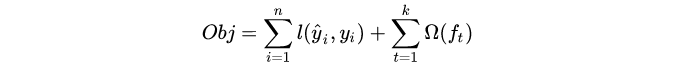

## 目标函数由模型的损失函数 $L$与抑制模型复杂度的正则项 $\Omega$组成

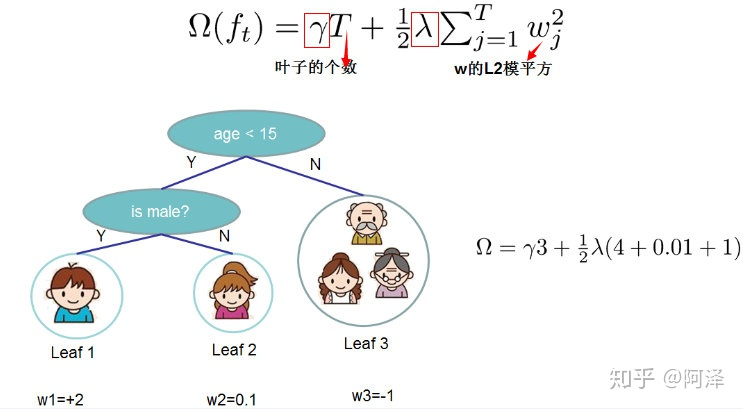

决策树的复杂度可由叶子数$T$组成，叶子节点越少模型越简单，此外叶子节点也不应该含有过高的权重$w$（权重尽量平均），所以目标函数的正则项可以定义为如上

<font size = 4>
    
高维：预排序
    
稀疏：先不要空值fit树，在给空值一个默认的方向
    
过拟合：正则项

## 优点

<font size = 3>
    
1、精度更高GBDT 只用到一阶泰勒展开，而 XGBoost 对损失函数进行了二阶泰勒展开。XGBoost 引入二阶导一方面是为了增加精度，另一方面也是为了能够自定义损失函数，二阶泰勒展开可以近似大量损失函数；
    
2、灵活性更强：GBDT 以 CART 作为基分类器，XGBoost 不仅支持 CART 还支持线性分类器，（使用线性分类器的 XGBoost 相当于带 L1 和 L2 正则化项的逻辑斯蒂回归（分类问题）或者线性回归（回归问题））。此外，XGBoost 工具支持自定义损失函数，只需函数支持一阶和二阶求导；
    
3、正则化：XGBoost 在目标函数中加入了正则项，用于控制模型的复杂度。正则项里包含了树的叶子节点个数、叶子节点权重的 L2 范式。正则项降低了模型的方差，使学习出来的模型更加简单，有助于防止过拟合；
    
4、Shrinkage（缩减）：相当于学习速率。XGBoost 在进行完一次迭代后，会将叶子节点的权重乘上该系数，主要是为了削弱每棵树的影响，让后面有更大的学习空间；
    
5、列抽样：XGBoost 借鉴了随机森林的做法，支持列抽样，不仅能降低过拟合，还能减少计算；
缺失值处理：XGBoost 采用的稀疏感知算法极大的加快了节点分裂的速度；
    
6、可以并行化操作：块结构可以很好的支持并行计算。
    


## 缺点

虽然利用预排序和近似算法可以降低寻找最佳分裂点的计算量，但在节点分裂过程中仍需要遍历数据集；

预排序过程的空间复杂度过高，不仅需要存储特征值，还需要存储特征对应样本的梯度统计值的索引，相当于消耗了两倍的内存。

# LightGBM

<font size = 3>XGBoost通过预排序的算法来寻找特征的最佳分裂点，虽然预排序算法能够准确的找出特征的分裂点，但该方法占用空间的代价太大，在数据量和特征量都比较多的情况下，会严重影响算法性能。XGBoost寻找最佳分裂点的算法复杂度可以估计为：

**复杂度=特征数量*特征分裂点的数量*样本数量**

既然XGBoost的复杂度是由特征数量、特征分裂点的数量和样本数量所决定的，那么LightGBM的优化空间自然是从这三个角度来考虑。

## 特征分裂点的数量 ——Histogram算法


<font size = 3>为了减少特征分裂点的数量和更加高效寻找最佳特征分裂点，LightGBM区别于XGBoost的预排序算法，采用Histogram直方图的算法寻找最佳特征分裂点。其基本想法是将连续的浮点特征值进行离散化为k个整数并构造一个宽度为k的直方图。对某个特征数据进行遍历的时候，将离散化后的值用为索引作为直方图的累积统计量。遍历完一次后，直方图便可累积对应的统计量，然后根据该直方图寻找最佳分裂点。
    
直方图算法并不什么特别的创新之举，本质上就是一种数据离散化和分箱操作，但架不住速度快性能优，计算代价和内存占用都大大减少。直方图另外一个好处在于差加速。一个叶子节点的直方图可由其父节点的直方图与其兄弟节点的直方图做差得到，这也可以加速特征节点分裂。

## 样本数量 ——GOSS全称为单边梯度抽样算法(Gradient-based One-Side Sampling)

**Adaboost算法的一个关键要素就是样本权重，通过在训练过程不断调整样本分类权重而达到最优分类效果的过程。但在GBDT系列中并没有样本权重的相关设计，GBDT采用样本梯度来代替权重的概念。一般来说，训练梯度小的样本，其经验误差也相对较小，说明这部分数据已经获得了较好的训练,但这样做可能会改变训练样本的数据分布，对最终的训练精度有影响。**

<font size = 3>针对以上问题，LightGBM提出采用GOSS采样算法。其目的就是最大效率的保留对计算信息增益有帮助的样本，提高模型训练速度。GOSS的基本做法是先将需要进行分裂的特征按绝对值大小降序排序，取绝对值最大的前a%个数据，假设样本大小为n，在剩下的(1-a%)个数据中随机选择b%个数据，将这b%个数据乘以一个常数(1-a%)/b%（希望能让这b%个数据替代原先的(1-a%)个数据，缩放一下），这种做法会使得算法更加关注训练不够充分的样本，并且原始的数据分布不会有太大改变。最后使用a+b个数据来计算该特征的信息增益。GOSS算法流程伪代码如下所示。

## 特征数量——EFB算法

<font size =3>EFB算法全称为互斥特征捆绑算法(Exclusive Feature Bundling)，通过将两个互斥的特征捆绑在一起，合为一个特征，在不丢失特征信息的前提下，减少特征数量，从而加速模型训练。大多数时候两个特征都不是完全互斥的，可以用定义一个冲突比率对特征不互斥程度进行衡量，当冲突比率较小时，可以将不完全互斥的两个特征捆绑，对最后的模型精度也没有太大影响。所谓特征互斥，即两个特征不会同时为非零值，这一点跟分类特征的one-hot表达有点类似

XGBoost采用按层生长的Level-Wise算法，好处是**可以多线程优化，也方便控制模型复杂度，且不易过拟合**。但缺点是**不加区分的对待同一层所有叶子节点，大部分的节点分裂和增益计算不是必须的，带来了多余的计算开销**。LightGBM提出了按叶子节点生长的Leaf-Wise算法，精度更高且更有效率，能够节约不必要的计算开销，同时为防止某一节点过分生长而加上一个深度限制机制，能够在保证精度的同时一定程度上防止过拟合。

# CatBoost

CatBoost通过对常规的目标变量统计方法添加先验项来对其进行改进。除此之外，CatBoost还考虑使用类别特征的不同组合来扩大数据集特征维度。

对于特征取值数目较多的类别型特征，一种折中的方法是将类别数目进行重新归类，使其类别数目降到较少数目再进行one-hot编码。另一种最常用的方法则是目标变量统计（Target Statisitics，TS），TS计算每个类别对于的目标变量的期望值并将类别特征转换为新的数值特征。CatBoost在常规TS方法上做了改进。CatBoost另外一种对类别特征处理方法的创新在于可以构建任意几个类别型特征的任意组合为新的特征。

CatBoost另一大创新点在于提出使用排序提升（Ordered Boosting）的方法解决预测偏移（Prediction Shift）的问题。

<font size=3>CatBoost与LightGBM开源前后时间相差不到3个月，二者都是在XGBoost基础上做出的改进和优化。除了算法整体性能上的差异之外，基于CatBoost最主要的类别型特征处理特色，三者的主要差异如下：

CatBoost支持最全面的类别型特征处理，可直接传入类别型特征所在列标识然后进行自动化处理。

LightGBM同样也支持对类别型特征的快速处理，训练时传入类别型特征列所在标识符即可。但LightGBM对于类别特征只是采用直接的硬编码处理，虽然速度较快但不如CatBoost的处理方法细致。

XGBoost作为最早的GBDT工程实现，其本身并不支持处理类别型特征，只能传入数值型数据。所以一般都需要手动对类别型特征进行one-hot等预处理。